In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from pprint import pprint

### Testando o carregamento do CSV do aprendizado da Q-table

In [3]:
qgye_csv = "qtb/qgye2/qgye2_a_15000_1000.csv"
qgye = pd.read_csv(qgye_csv, sep=";")
qgye.head()

,episode,epsilon,steps,dones,truncs,total_seconds,q_table_zeros
0,0,0.0,0,0,0,0.000000,3000
1,1,0.1,493,1,0,0.056299,2737
2,2,0.1,1000,1,1,0.170006,2276
3,3,0.1,529,2,1,0.226841,2137
4,4,0.1,231,3,1,0.251402,2137


Cálculo de número de steps até determinado episódio

In [4]:
qgye[qgye['episode']<=200]['steps'].sum()

63934

Cálculo de segundos corridos até determinado episódio

In [5]:
num = qgye.iloc[200]['total_seconds']
num

6.82568

Função que carrega CSV do aprendizado em dataframe

In [6]:
@lru_cache(maxsize=100)
def get_qgye(
    epsilon_option,
    num_episodes,
    max_steps,
):
    qgye_csv = f"qtb/qgye2/qgye2_{epsilon_option}_{num_episodes}_{max_steps}.csv"
    qgye = pd.read_csv(qgye_csv, sep=";")
    return qgye

Função que pega total de steps e segundos de um episódio de um CSV de aprendizagem

In [7]:
@lru_cache(maxsize=100)
def steps_secs(
    epsilon_option,
    num_episodes,
    max_steps,
    episode,
):
    qgye = get_qgye(
        epsilon_option,
        num_episodes,
        max_steps,
    )
    steps = qgye[qgye['episode']<=episode]['steps'].sum()
    total_seconds = qgye.iloc[episode]['total_seconds']
    return steps, total_seconds

Teste

In [8]:
steps_secs('a', 15000, 1000, 300)

(77224, 8.259225)

### Carregando o arquivo de avaliação da aprendizagem

In [9]:
eval_file_name = "qtb/qgye2/qeval.txt"

In [10]:
columns = ['epsilon_type','train_episodes','percent_dones','avg_steps']
qeval = pd.read_csv(eval_file_name, sep=";", header=None, names=columns)
qeval.head()

,epsilon_type,train_episodes,percent_dones,avg_steps
0,d,13900,99.33,13.040268
1,a,7400,81.33,12.631148
2,f,4000,93.67,12.836299
3,g,10200,100.00,13.070000
4,e,10400,94.33,12.932862


Adicionando ao dataframe de avaliação os steps e os segundos

In [11]:
qeval['steps'] = qeval.apply(
    lambda x: steps_secs(
        x['epsilon_type'], 15000, 1000, x['train_episodes']
    )[0],
    axis=1,
)
qeval['total_seconds'] = qeval.apply(
    lambda x: steps_secs(
        x['epsilon_type'], 15000, 1000, x['train_episodes']
    )[1],
    axis=1,
)
qeval.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds
0,d,13900,99.33,13.040268,784419,113.452929
1,a,7400,81.33,12.631148,231349,26.333159
2,f,4000,93.67,12.836299,419299,69.103914
3,g,10200,100.00,13.070000,7946622,1162.616029
4,e,10400,94.33,12.932862,421043,61.208309


Coluna train_episodes passa a ser em centenas

In [12]:
qeval['train_episodes'] = qeval['train_episodes'] / 100
qeval.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds
0,d,139.0,99.33,13.040268,784419,113.452929
1,a,74.0,81.33,12.631148,231349,26.333159
2,f,40.0,93.67,12.836299,419299,69.103914
3,g,102.0,100.00,13.070000,7946622,1162.616029
4,e,104.0,94.33,12.932862,421043,61.208309


Separa dataframe por tipos de épsilons

In [13]:
evals={}
for e_type in 'abcdefg':
    eval_t = qeval[qeval['epsilon_type']==e_type].sort_values('train_episodes')[['train_episodes', 'percent_dones', 'avg_steps', 'steps', 'total_seconds']]
    evals[e_type] = eval_t.set_index('train_episodes')
evals["a"].head()

,percent_dones,avg_steps,steps,total_seconds
train_episodes,,,,
1.0,0.00,0.000000,44523,4.744126
2.0,0.33,7.000000,63934,6.825680
3.0,0.33,6.000000,77224,8.259225
4.0,4.00,8.416667,86240,9.231001
5.0,10.67,9.187500,94775,10.152999


Testa visualização da aprendizagem de um tipo de épsilon

Text(0.5, 0, 'train episodes')

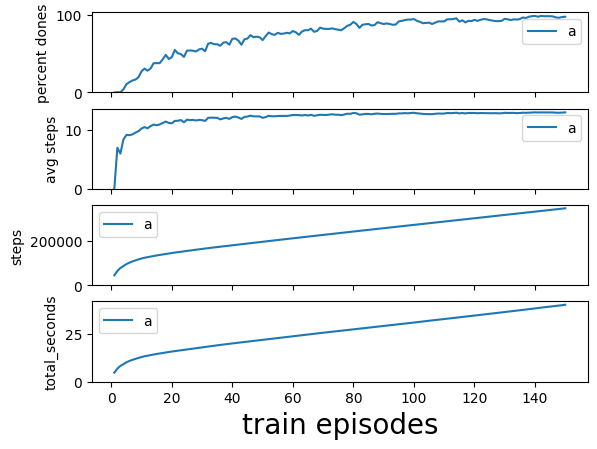

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True)

# ax[0].set_title("percent dones", size = 20)
e='a'

ax[0].plot(evals[e]['percent_dones'])
ax[0].legend([e])
ax[0].set_ylabel("percent dones")
ax[0].set_ylim(bottom=0)

ax[1].plot(evals[e]['avg_steps'])
ax[1].legend([e])
ax[1].set_ylabel("avg steps")
ax[1].set_ylim(bottom=0)

ax[2].plot(evals[e]['steps'])
ax[2].legend([e])
ax[2].set_ylabel("steps")
ax[2].set_ylim(bottom=0)

ax[3].plot(evals[e]['total_seconds'])
ax[3].legend([e])
ax[3].set_ylabel("total_seconds")
ax[3].set_ylim(bottom=0)

ax[3].set_xlabel("train episodes", size = 20)

Visualização de comparação de todos os tipos de épsilons

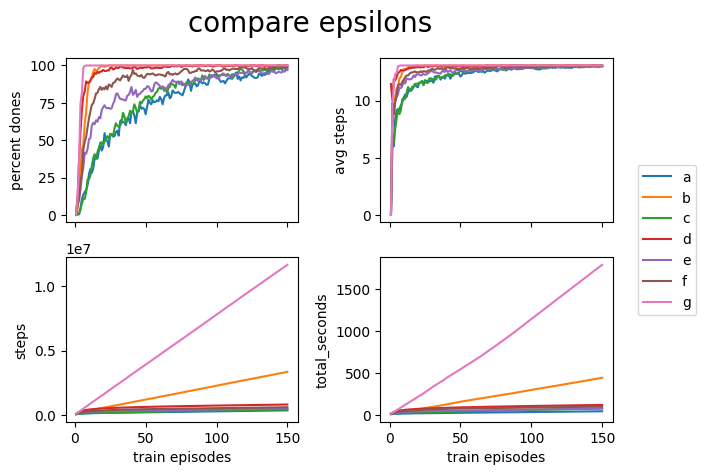

In [21]:
fig, ax = plt.subplots(2, 2, sharex=True)

for e in evals:
    ax[0, 0].plot(evals[e]['percent_dones'])
    ax[0, 1].plot(evals[e]['avg_steps'])
    ax[1, 0].plot(evals[e]['steps'])
    ax[1, 1].plot(evals[e]['total_seconds'])

fig.suptitle("compare epsilons", size = 20)

ax[0, 0].set_ylabel("percent dones")
# ax[0].set_ylim(bottom=0)

ax[0, 1].set_ylabel("avg steps")
# ax[1].set_ylim(bottom=0)

ax[1, 0].set_ylabel("steps")

ax[1, 0].set_xlabel("train episodes")

ax[1, 1].set_ylabel("total_seconds")

ax[1, 1].set_xlabel("train episodes")

fig.legend(evals.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Montando dict de dataframes de apenas com qtables com percent_dones 100%

[não utilizado adiante]

In [16]:
dones={}
for e_type in 'abcdefg':
    eval_t = qeval[(qeval['epsilon_type']==e_type) & (qeval['percent_dones']==100)].sort_values('train_episodes')[['train_episodes', 'avg_steps']]
    dones[e_type] = eval_t.set_index('train_episodes')
dones["b"].head()

,avg_steps
train_episodes,
19.0,13.07
24.0,13.07
25.0,13.07
26.0,13.07
27.0,13.07


Montando q100, fitrando arquivo de avaliação da aprendizagem por percent_dones 100%

In [17]:
q100 = qeval[qeval['percent_dones']==100]
q100.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds
3,g,102.0,100.0,13.07,7946622,1162.616029
8,g,67.0,100.0,13.07,5228872,726.554303
9,b,118.0,100.0,13.07,2650542,345.339188
12,d,102.0,100.0,13.07,723998,103.670721
14,g,60.0,100.0,13.07,4677987,647.939199


Do q100, pegando apenas o primeiro episódio com percent_dones 100%, para comparar steps (em dezenas de milhares) e segundos

In [18]:
q_min_episodes = q100.groupby(by=['epsilon_type']).aggregate({
    'train_episodes': ['min'],
    'steps': ['min'],
    'total_seconds': ['min'],
})
q_min_episodes['steps'] = q_min_episodes['steps'] / 10_000
q_min_episodes.head()

,train_episodes,steps,total_seconds
,min,min,min
epsilon_type,,,
b,19.0,52.5793,62.384328
d,69.0,66.1484,93.913682
g,8.0,63.2185,84.241177


Colocando os dados acima em um gráfico se percebe que:
- a ordem dos tipos de epsilon quanto à steps é o mesmo que quanto a segundos (steps e segundos são diretamente relacionados);
- porém, a ordem dos tipos de epsilon quanto à steps e episódios não é a mesma.

Apesar do épsilom 0.99 ter chegado no q-table 100% em menos episódios, o épsilom 0.9 chegou ao mesmo em menos steps (que é proporcional aos segundos).

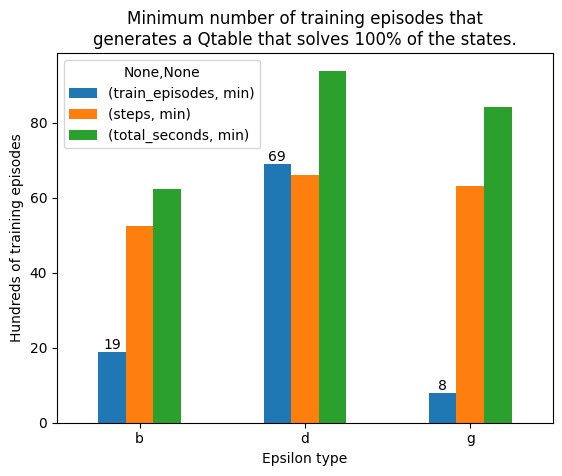

In [19]:
fig = q_min_episodes.plot(kind='bar')
plt.title('Minimum number of training episodes that\ngenerates a Qtable that solves 100% of the states.')
plt.xlabel('Epsilon type')
plt.ylabel('Hundreds of training episodes')
plt.xticks(rotation=0)
fig.bar_label(fig.containers[0], label_type='edge')
plt.show()